# Latent Recovery of GAN

https://www.easy-tensorflow.com/tf-tutorials/basics/save-and-restore

In [1]:
from src import models

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(100)

In [3]:
import tensorflow as tf
tf.set_random_seed(100)

In [4]:
from keras.utils import Progbar

## Load Data

In [5]:
from keras.datasets import mnist

In [6]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [7]:
def batch_generator(X, labels, batch_size=64):
    while True:
        choice = np.random.choice(len(X), batch_size, replace=False)
        X_batch = X[choice][..., np.newaxis]
        X_batch = X_batch / 127.5 - 1.
        y_batch = labels[choice][:, np.newaxis]
        yield X_batch, y_batch

In [8]:
test_batch, test_labels = next(batch_generator(X_train, y_train))

In [9]:
def plot_batch(batch):
    plt.figure(figsize=(15,3))
    for i, img in enumerate(batch):
        plt.subplot(1, len(batch), i + 1)
        plt.imshow(0.5 * (img.squeeze() + 1.), cmap=plt.cm.gray)
        plt.axis("off")
    plt.show()

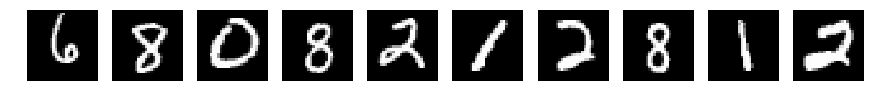

In [10]:
plot_batch(test_batch[:10])

In [11]:
test_batch.shape

(64, 28, 28, 1)

## Build Models

In [12]:
img_shape = (28,28,1)
latent_dim = 100
nb_blocks = 2
nb_filters = 64
lambda_reg = 10

In [13]:
with tf.variable_scope("discriminator"):
    D = models.DC_discriminator(img_shape, nb_blocks+2, nb_filters)

In [14]:
# D.summary()

In [15]:
with tf.variable_scope("generator"):
    G = models.DC_generator(img_shape, latent_dim, nb_blocks, nb_filters)

In [16]:
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
activation_2 (Activation)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       409728    
_________________________________________________________________
activation_3 (Activation)    (None, 14, 14, 128)       0         
__________

## Restore Models

In [17]:
log_dir = "./logs/mnist-wgan-gp-2"

In [18]:
sess = tf.Session()
saver = tf.train.Saver()

In [19]:
# restore the saved vairable
saver.restore(sess, "./logs/mnist-wgan-gp-2-10000")

INFO:tensorflow:Restoring parameters from ./logs/mnist-wgan-gp-2-10000


In [20]:
g_input = tf.placeholder('float32', (None, latent_dim))
g_out = G(g_input)

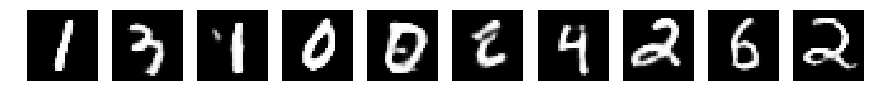

In [21]:
zz = np.random.normal(0., 1., (10, latent_dim))
plot_batch(sess.run(g_out, feed_dict={g_input : zz}))

## Recover Latent Variable

In [22]:
batch_size = 1
latent_init = np.random.normal(0., 1., (batch_size, latent_dim))
latent_recon = tf.Variable(latent_init, dtype="float32")

In [23]:
images = tf.placeholder("float32", (batch_size,) + img_shape)
recon_loss = tf.losses.mean_squared_error(images, G(latent_recon))
recon_opt = tf.train.AdamOptimizer(learning_rate=0.01).minimize(recon_loss, var_list=[latent_recon])

In [24]:
generator = batch_generator(X_train, y_train, batch_size)

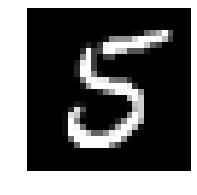

In [25]:
plot_batch(next(generator)[0][:10])

In [26]:
sess.run(tf.global_variables_initializer())

In [27]:
nb_epochs = 2
iter_per_epoch = 10000

test_images, test_labels = next(generator)
print(test_images.shape, test_labels.shape)

losses = []

for e in range(nb_epochs):
    print("Epoch {}/{}".format(e + 1, nb_epochs))
    progbar = Progbar(iter_per_epoch)
    
    for it in range(iter_per_epoch):
        sess.run(recon_opt, feed_dict={images : test_images})
        loss = sess.run(recon_loss, feed_dict={images : test_images})
        losses.append(loss)

        progbar.update(it + 1, values=[("loss", loss)])

(1, 28, 28, 1) (1, 1)
Epoch 1/2
10000/10000 [==============================] - 38s 4ms/step - loss: 0.0762
Epoch 2/2
10000/10000 [==============================] - 155s 16ms/step - loss: 0.0039


In [28]:
test_latent_recon = sess.run(latent_recon)

In [29]:
test_latent_recon.shape

(1, 100)

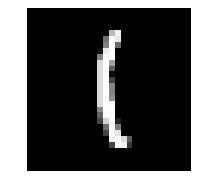

In [30]:
plot_batch(test_images[:10])

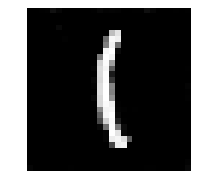

In [31]:
plot_batch(sess.run(g_out, feed_dict={g_input : test_latent_recon})[:10])

## TSNE

In [32]:
from sklearn.manifold import TSNE

In [33]:
tsne = TSNE(n_components=2, verbose=1)
tsne_results = tsne.fit_transform(test_latent_recon)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 100 samples in 0.000s...
[t-SNE] Computed neighbors for 100 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 100 / 100
[t-SNE] Mean sigma: 77.606262
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.402283
[t-SNE] KL divergence after 1000 iterations: 0.894581


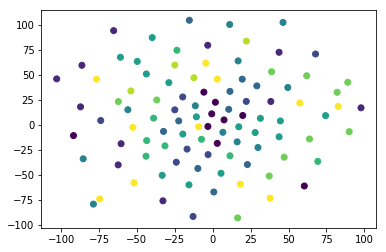

In [37]:
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=test_labels.squeeze())
plt.show()